In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_context('notebook')
from tensorflow.contrib import predictor

import sklearn
from sklearn.dummy import DummyClassifier
from sklearn import metrics

/data/miniconda3/envs/zoobot/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/data/miniconda3/envs/zoobot/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
import sys
sys.path.insert(0, '/Data/repos/zoobot')
from zoobot.tfrecord import catalog_to_tfrecord

### What's the Problem?

Given a galaxy image, we want to know if the galaxy is 'smooth' or featured.

We have a set of crowdsourced answers. Each galaxy has about 40 responses. 

Let's aim to predict the crowd majority vote.

### Look at the crowd labels

Load all crowd answers. How common is each response?

In [47]:
size = 128
label_split = 0.5
channels = 3

In [5]:
columns_to_save = [
    'smooth-or-featured_smooth',
    'smooth-or-featured_featured-or-disk',
    'smooth-or-featured_total-votes',
    'smooth-or-featured_smooth_fraction',
    'smooth-or-featured_featured-or-disk_fraction',
    'smooth-or-featured_smooth_min',
    'smooth-or-featured_smooth_max',
    'smooth-or-featured_featured-or-disk_min',
    'smooth-or-featured_featured-or-disk_max',
    'smooth-or-featured_prediction-encoded',  # 0 for artifact, 1 for featured, 2 for smooth
    'classifications_count',
    'subject_id',
    'nsa_id',
    'ra',
    'dec']

df_loc = '/data/repos/zoobot/zoobot/data/panoptes_featured_s{}_l{}_train.tfrecord.csv'.format(size, label_split)
df = pd.read_csv(df_loc, usecols=columns_to_save + ['fits_loc', 'png_loc', 'png_ready'], dtype={'fits_loc': str})

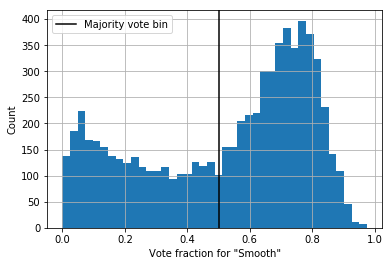

In [6]:
fraction_col = 'smooth-or-featured_smooth_fraction'
df['label'] = df[fraction_col] > 0.5
ax = df[fraction_col].hist(bins=40)
ax.axvline(0.5, c='k')
plt.xlabel('Vote fraction for "Smooth"')
plt.ylabel('Count')
plt.legend(['Majority vote bin'])

In [7]:
print(df['smooth-or-featured_prediction-encoded'].value_counts())
print(df[fraction_col].mean())

2    4626
1    2436
Name: smooth-or-featured_prediction-encoded, dtype: int64
0.5232959079908861


In [8]:
print(df['smooth-or-featured_smooth_fraction'].mean())
print(df['smooth-or-featured_featured-or-disk_fraction'].mean())

0.5232959079908861
0.35451438332808705


The crowd somewhat separates 'smooth' from 'featured' galaxies, but there's clearly a continuum. 

Let's start with the binary case (what would the majority say) and then move on to regression (what fraction would say 'smooth).

In [9]:
'Fraction of galaxies which the crowd thinks are smooth: {:.2f}%'.format(np.mean((df[fraction_col] > 0.5).astype(float)))

'Fraction of galaxies which the crowd thinks are smooth: 0.60%'

Smooth galaxies are a little less common than featured galaxies - bear this in mind when looking at accuracy. A dumb majority class classifier would get 60% accuracy.

## How accurate are the model samples on test data?

### Load the the test catalog (galaxy labels)

In [94]:
n_examples = 200

In [95]:
# data_loc = '/data/repos/zoobot/zoobot/data/panoptes_featured_s64_l0.5'
data_loc = '/data/repos/zoobot/zoobot/data/panoptes_featured_s128_l0.4'

In [96]:
train_df = pd.read_csv(data_loc + '_train.tfrecord.csv')
train_data = train_df[:n_examples]  # index will match tfrecord examples

In [97]:
test_df = pd.read_csv(data_loc + '_test.tfrecord.csv')
test_data = test_df[:n_examples]  # index will match tfrecord examples

### Load galaxy examples from tfrecord

In [98]:
def load_examples_from_tfrecord(tfrecord_loc, n_examples):
    # see http://www.machinelearninguru.com/deep_learning/tensorflow/basics/tfrecord/tfrecord.html
    with tf.Session() as sess:
        # Create a list of filenames and pass it to a queue
        filename_queue = tf.train.string_input_producer([tfrecord_loc], num_epochs=1)
        # Define a reader and read the next record
        reader = tf.TFRecordReader()
        _, serialized_example = reader.read(filename_queue)

        # Initialize all global and local variables
        init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        sess.run(init_op)
        # Create a coordinator and run all QueueRunner objects
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)

        # execute
        return [sess.run(serialized_example) for n in range(n_examples)]


In [37]:
tfrecord_loc = data_loc + '_train.tfrecord'
train_examples = load_examples_from_tfrecord(tfrecord_loc, n_examples)

In [100]:
tfrecord_loc = data_loc + '_test.tfrecord'
test_examples = load_examples_from_tfrecord(tfrecord_loc, n_examples)

Double check that these have genuinely different data:

In [101]:
print(len(train_examples))
print(len(test_examples))

200
200


In [102]:
train_examples[0] == test_examples[0]

False

In [103]:
print(train_examples[0][:10])
print(test_examples[0][:10])

b"\n\xdd\x86\x0c\n3\n'sm"
b'\n\xdd\x86\x0c\n+\n\x1fsm'


Double check that tfrecord and data catalog indices align i.e. first example from tfrecord is first example in data catalog, etc.

In [104]:
def parse_example(example):
    with tf.Session() as sess:
        
            features = {
                'matrix': tf.FixedLenFeature((size * size * channels), tf.float32),
                'label': tf.FixedLenFeature([], tf.int64),
              }

            parsed_example = tf.parse_single_example(example, features=features)
            return sess.run(parsed_example)

In [288]:
%%timeit

parse_example(train_examples[0])

709 ms ± 22.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [289]:
parse_example(train_examples[0])

{'label': 0,
 'matrix': array([20., 19., 18., ..., 24., 29., 23.], dtype=float32)}

In [105]:
train_record_labels = [parse_example(train_examples[n])['label'] for n in range(30)]
train_data_labels = train_df['label'][:30]

KeyboardInterrupt: 

In [ ]:
print(train_record_labels)
print(list(train_data_labels.values))
assert (train_record_labels == train_data_labels.values).all()

 View saved image

In [ ]:
def show_example(example, ax=None):
    im = example['matrix'].reshape(size, size, channels).astype(int)  # saved as floats but truly int, show as int
    label = example['label']
    im.shape
    if ax is None:
        ax = plt
    ax.imshow(im)
    ax.text(50, 50, label, fontsize=16, color='r')

In [ ]:
def show_examples(n_examples):
    fig, axes = plt.subplots(nrows=n_examples, figsize=(4, 40))
    for n in range(n_examples):
        show_example(parse_example(train_examples[n]), ax=axes[n])
    fig.tight_layout

In [ ]:
show_examples(20)

In tfrecord, label 1 means smooth

### What do we have to beat?

In [ ]:
dummy_classifier = DummyClassifier(strategy='most_frequent', random_state=None, constant=None)
dummy_classifier.fit(np.random.rand(len(train_df), 1), train_df['label'])
metrics.accuracy_score(test_df['label'], dummy_classifier.predict(np.random.rand(len(test_df), 1)))

### Train Bayesian CNN

See https://github.com/RustyPanda/zoobot/tree/master/zoobot

Training is done on .tfrecord files after a simple 80/20 train/test split.

### Load saved models at untrained, mid-training and trained stages

In [106]:
untrained_model_loc = '/Data/repos/zoobot/zoobot/runs/bayesian_panoptes_featured_si128_sf64_l0.4_augs_both_normed_activated_wide/1530201507'  # needs update
midtrained_model_loc = '/Data/repos/zoobot/zoobot/runs/bayesian_panoptes_featured_si128_sf64_l0.4_augs_both_normed_activated_wide/1530242652' 
trained_model_loc = '/Data/repos/zoobot/zoobot/runs/bayesian_panoptes_featured_si128_sf64_l0.4_augs_both_normed_activated_wide/1530286779' 


untrained_model_unwrapped = predictor.from_saved_model(untrained_model_loc)
midtrained_model_unwrapped = predictor.from_saved_model(midtrained_model_loc)
trained_model_unwrapped = predictor.from_saved_model(trained_model_loc)

# wrap to avoid having to pass around dicts all the time
untrained_model = lambda x: 1 - untrained_model_unwrapped({'examples': x})['predictions_for_true']
midtrained_model = lambda x: 1 - midtrained_model_unwrapped({'examples': x})['predictions_for_true']
trained_model = lambda x: 1 - trained_model_unwrapped({'examples': x})['predictions_for_true']

models = [untrained_model, midtrained_model, trained_model]

INFO:tensorflow:Restoring parameters from b'/Data/repos/zoobot/zoobot/runs/bayesian_panoptes_featured_si128_sf64_l0.4_augs_both_normed_activated_wide/1530201507/variables/variables'
INFO:tensorflow:Restoring parameters from b'/Data/repos/zoobot/zoobot/runs/bayesian_panoptes_featured_si128_sf64_l0.4_augs_both_normed_activated_wide/1530242652/variables/variables'
INFO:tensorflow:Restoring parameters from b'/Data/repos/zoobot/zoobot/runs/bayesian_panoptes_featured_si128_sf64_l0.4_augs_both_normed_activated_wide/1530286779/variables/variables'


### Make model predictions

In [123]:
n_examples = 200  # number of train/test examples to make predictions on

In [269]:
def get_samples_of_examples_old(model, examples, n_samples):
    results = np.zeros((len(examples), n_samples))
    
    # for speed, concat examples n_samples times and make one 'predict' call
    for nth_run in range(n_samples):  # for each desired sample,
        
        results[:, nth_run] = model(examples)  # predict once on every example
    return results
# TODO refactor so that n_samples is not a new model load, but rather a copy of the same examples that's later transformed out again

In [270]:
def get_samples_of_examples(model, examples, n_samples):
    
    results = np.zeros((len(examples), n_samples))
    
    # for speed, concat examples n_samples times and make one 'predict' call
    
    copied_examples = examples * n_samples
    linear_results = model(copied_examples)
    
    for nth_run in range(n_samples):  # for each desired sample,
        results_of_run = linear_results[nth_run * len(examples):(nth_run + 1) * len(examples)]
        
        results[:, nth_run] =  results_of_run # predict once on every example
    
    return results
# TODO refactor so that n_samples is not a new model load, but rather a copy of the same examples that's later transformed out again

In [271]:
%%timeit

model_train_results = [get_samples_of_examples(model, train_examples[:5], 10) for model in models]

1.27 s ± 41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [272]:
%%timeit

model_train_results = [get_samples_of_examples_old(model, train_examples[:5], 10) for model in models]

1.21 s ± 24.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [287]:
train_examples[0]

b'\n\xdd\x86\x0c\n3\n\'smooth-or-featured_featured-or-disk_min\x12\x08\x12\x06\n\x04m6.?\n\x11\n\x06nsa_id\x12\x07\x1a\x05\n\x03\xe5\xdd\x01\n\x0f\n\x03dec\x12\x08\x12\x06\n\x04\x9b\xa3\x0f\xbf\n\x16\n\nsubject_id\x12\x08\x1a\x06\n\x04\x9b\x8a\xd6\t\n\'\n\x1bsmooth-or-featured_artifact\x12\x08\x12\x06\n\x04\x00\x00\x00@\n+\n\x1fsmooth-or-featured_artifact_max\x12\x08\x12\x06\n\x04\xc6\x8d\xea=\n\x94\x80\x0c\n\x06matrix\x12\x88\x80\x0c\x12\x84\x80\x0c\n\x80\x80\x0c\x00\x00\xa0A\x00\x00\x98A\x00\x00\x90A\x00\x00\x88A\x00\x00\x88A\x00\x00\x90A\x00\x00pA\x00\x00\x88A\x00\x00\x88A\x00\x00`A\x00\x00pA\x00\x00`A\x00\x00PA\x00\x00`A\x00\x00PA\x00\x00\x80A\x00\x00pA\x00\x00pA\x00\x00\x80A\x00\x00\x80A\x00\x00\x80A\x00\x00\xa0A\x00\x00\xa0A\x00\x00\xb8A\x00\x00\x90A\x00\x00pA\x00\x00\x90A\x00\x00`A\x00\x00pA\x00\x00\x88A\x00\x00\xa0A\x00\x00\x88A\x00\x00\x88A\x00\x00\x90A\x00\x00\x98A\x00\x00\xa8A\x00\x00\x98A\x00\x00\x88A\x00\x00\x98A\x00\x00\xa8A\x00\x00\x98A\x00\x00\xc0A\x00\x00\xc8A\x00\x00\

In [284]:
0.011 * 350e3 / 60  # 1 hour to make 1 prediction on every galaxy, not including loading the galaxies from tfrecord

64.16666666666667

In [285]:
0.011 * 200 * 500 * 3 / 60  # 1 hour to make 500 predictions on 200 galaxies for 3 models 

54.999999999999986

In [277]:
%%timeit

model_train_results = get_samples_of_examples_old(models[2], train_examples[:1], 1)

11 ms ± 226 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [274]:
%%timeit

model_train_results = [get_samples_of_examples_old(model, train_examples[:1], 10) for model in models]

325 ms ± 16.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [275]:
%%timeit

model_train_results = [get_samples_of_examples_old(model, train_examples[:10], 1) for model in models]

270 ms ± 1.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [276]:
%%timeit

model_train_results = [get_samples_of_examples_old(model, train_examples[:10], 10) for model in models]

2.63 s ± 32.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [125]:
train_labels = np.array(list(map(lambda x: parse_example(x)['label'], train_examples[:n_examples]))).astype(bool)
test_labels = np.array(list(map(lambda x: parse_example(x)['label'], test_examples[:n_examples]))).astype(bool)

In [126]:
assert all(train_labels == train_df['label'][:len(train_labels)])
assert all(test_labels == test_df['label'][:len(test_labels)])

In [219]:
n_samples = 500  # predict this many times per example
model_train_results = [get_samples_of_examples(model, train_examples[:n_examples], n_samples) for model in models]
model_test_results = [get_samples_of_examples(model, test_examples[:n_examples], n_samples) for model in models]

KeyboardInterrupt: 

In [ ]:
def roc_comparison(results, labels, ax):
    for n in range(len(models)):
        fpr, tpr, _ = metrics.roc_curve(labels, np.mean(results[n], axis=1)) 
        ax.plot(fpr, tpr)
    ax.plot([0.0, 1.0], [0.0, 1.0], 'k--')
    ax.legend(['Untrained', 'Midtrained', 'Trained', 'Random'])
    return ax

In [ ]:
fig, (ax0, ax1) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))
roc_comparison(model_train_results, train_labels, ax0)
roc_comparison(model_test_results, test_labels, ax1)
ax0.set_title('Train Mean ROC')
ax1.set_title('Test Mean ROC')
fig.tight_layout()

In [ ]:
def roc_histograms(model_run_results, model_labels):
    n_trials = 200  # calculate this many ROC curves for each model, by choosing a random sample column for all examples each time
    colors = ['r', 'b', 'k']
    fig, axes = plt.subplots(ncols=len(model_run_results), figsize=(12, 4), sharex=True, sharey=True)
    for model_n in range(len(model_run_results)):
        
        model_results = model_run_results[model_n]
        color = colors[model_n]
        all_fpr, all_tpr = [], []
        
        for trial_n in range(n_trials):
            fpr, tpr, _ = metrics.roc_curve(model_labels, list(map(lambda x: np.random.choice(x), model_results[:])))
            all_fpr = all_fpr + list(fpr)
            all_tpr = all_tpr + list(tpr)

        axes[model_n].hist2d(all_fpr, all_tpr, bins=100, cmax=n_trials/10)
        axes[model_n].plot([0.0, 1.0], [0.0, 1.0], 'r')
        # sns.jointplot(all_fpr, all_tpr, kind="hex")

    axes[0].set_title('Untrained')
    axes[1].set_title('Midtrained')
    axes[2].set_title('Final Trained')
    for ax in axes:
        ax.set_xlabel('Completeness')
        ax.set_ylabel('Contamination')
    fig.tight_layout()

    # TODO: do this properly, using thresholds output of roc curve to compare between runs. Perhaps show the kde surface - but uneven sampling might be a problem

In [ ]:
roc_histograms(model_train_results, train_labels)

In [ ]:
roc_histograms(model_test_results, test_labels)

It appears to be pretty much random how well each model performs

### What do the sample distributions of the trained model look like?

In [ ]:
def entropy(p_values):
    return -np.sum(list(map(lambda p: p * np.log(p), p_values)))

In [ ]:
def view_samples(scores, labels, selected=None):
    
    if selected is not None:
        scores = scores[selected]
        labels = labels[selected]
        
    correct = np.mean(scores, axis=1).astype(bool) == labels
    fig, axes = plt.subplots(len(labels), figsize=(4, len(labels)), sharex=True)
    for galaxy_n, ax in enumerate(axes):
        hist_data = ax.hist(scores[galaxy_n])
        c='r'
        if correct[galaxy_n]:
            c='g'
        
        lbound = 0
        ubound = 0.5
        if scores[galaxy_n].mean() > 0.5:
            lbound = 0.5
            ubound = 1
            
        ax.axvspan(lbound, ubound, alpha=0.1, color=c)
        ax.text(0.7, 0.75 * np.max(hist_data[0]), 'H: {}'.format(str(entropy(scores[galaxy_n]))[:4]))
#         ax.text(0.1, 400, '{}'.format(galaxy_n))
        ax.set_xlim([0, 1])

#### Sample distributions on train data with untrained model

In [ ]:
selected = np.arange(20)
view_samples(model_train_results[0], train_labels, selected=selected)

In [ ]:
# selected = [18, 20, 23, 71, 78, 82, 91]
# view_samples(model_train_results[0], train_labels, selected=selected)

#### Sample distributions on train data with trained model

In [ ]:
view_samples(model_train_results[2], train_labels, selected=np.arange(20))

#### Sample distributions on train data with trained model

In [ ]:
view_samples(model_test_results[2], test_labels, selected=np.arange(20))

In [ ]:
# write the indices and make only those into a plot (1k samples)